In [2]:
# 导包
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from plot_confusion_matrix import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn import svm

Using TensorFlow backend.


In [3]:
# 读取数据
# 根据题意，先把header设置好
headers = ['age', 'workclass', 'fnlwgt',
           'education', 'education_num', 'marital_status',
           'occupation', 'relationship', 'race',
           'sex', 'capital_gain', 'capital_loss',
           'hours_per_week', 'native_country', 'income']

# 读取训练集进入内存
train_data = pd.read_csv("data/adult_train.csv",names=headers)

# 对于测试集，他的第一行是一个分隔，不读入
test_data = pd.read_csv("data/adult_test.csv",names=headers,skiprows=[0])

In [4]:
# 看看训练集有多少数据
train_data.shape

(32561, 15)

In [5]:
# 看看数据是怎么样的，平均值；最大最小值，标准差等等（只有连续性的）
train_data.describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [6]:
train_data['source']='train'
test_data['source']='test'
test_data['income']= test_data['income'].apply(lambda x: x[0:-1])
data= pd.concat([train_data, test_data],axis=0,ignore_index=True)


In [7]:
# 数据中有一些值是？，用python的NaN代替方便以后直接当作空值处理
data = data.replace('[?]', np.NaN, regex=True)

In [8]:
# 对于缺失属性的数据直接删除
data = data.dropna()
data.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
source            0
dtype: int64

In [9]:
# 开始处理离散数据
# income我们需要将其映射一下
# 先将>=50K的映射成1，<=50K的设置为0
le= LabelEncoder()
data['income']= le.fit_transform(data['income'])

data['income'].value_counts()


0    34014
1    11208
Name: income, dtype: int64

In [10]:
# 取出所有的离散量属性
discrete = [x for x in data.columns if train_data[x].dtype=='object']
discrete.remove('source')

In [11]:
# 看看这些离散量属性的取值分布
for i in discrete:
    print(train_data[i].value_counts())
    

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64
 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital_status, dtype: int64
 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial

In [12]:
# 看看education_num这个连续量
train_data['education'].value_counts()

 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 11th             1175
 Assoc-acdm       1067
 10th              933
 7th-8th           646
 Prof-school       576
 9th               514
 12th              433
 Doctorate         413
 5th-6th           333
 1st-4th           168
 Preschool          51
Name: education, dtype: int64

In [13]:
# 发现跟education一样的，重复了，因为eudcation是离散的，不好处理。去掉这个属性
data = data.drop(columns=['education'])

In [14]:
# 看看相关系数矩阵,检查一下连续变量。发现序号属性不太影响最后的收入
data.corr()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.075792,0.037623,0.079683,0.059351,0.101992,0.237040
fnlwgt,-0.075792,1.000000,-0.041993,-0.004110,-0.004349,-0.018679,-0.007264
education_num,0.037623,-0.041993,1.000000,0.126907,0.081711,0.146206,0.332800
capital_gain,0.079683,-0.004110,0.126907,1.000000,-0.032102,0.083880,0.221034
capital_loss,0.059351,-0.004349,0.081711,-0.032102,1.000000,0.054195,0.148687
hours_per_week,0.101992,-0.018679,0.146206,0.083880,0.054195,1.000000,0.227199
income,0.237040,-0.007264,0.332800,0.221034,0.148687,0.227199,1.000000


In [15]:
# 把序号属性删掉
data = data.drop(columns=['fnlwgt'])

In [16]:
discrete2 = [x for x in data.columns if data[x].dtype=='object']
discrete2.remove('source')
discrete2

['workclass',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

In [17]:
# 进行哑编码
data = pd.get_dummies(data, columns=discrete2, drop_first=True)

In [18]:
# 看看编码后的结果
data.columns

Index(['age', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income', 'source', 'workclass_ Local-gov',
       'workclass_ Private', 'workclass_ Self-emp-inc',
       'workclass_ Self-emp-not-inc', 'workclass_ State-gov',
       'workclass_ Without-pay', 'marital_status_ Married-AF-spouse',
       'marital_status_ Married-civ-spouse',
       'marital_status_ Married-spouse-absent',
       'marital_status_ Never-married', 'marital_status_ Separated',
       'marital_status_ Widowed', 'occupation_ Armed-Forces',
       'occupation_ Craft-repair', 'occupation_ Exec-managerial',
       'occupation_ Farming-fishing', 'occupation_ Handlers-cleaners',
       'occupation_ Machine-op-inspct', 'occupation_ Other-service',
       'occupation_ Priv-house-serv', 'occupation_ Prof-specialty',
       'occupation_ Protective-serv', 'occupation_ Sales',
       'occupation_ Tech-support', 'occupation_ Transport-moving',
       'relationship_ Not-in-family', 'relationship_ Oth

In [19]:
# 将非2值类型的数据进行标准化
num = [x for x in data.columns if data[x].dtype=='int64']
scaler = StandardScaler()
data.loc[:, num] = scaler.fit_transform(data.loc[:, num])

In [20]:
train_data = data.loc[data['source']=='train',:]
test_data = data.loc[data['source']=='test',:]

In [21]:
# 把要预测的值income单独拿出来看看
y_train = np.array(train_data.income)
x_train = np.array(train_data.drop(['income','source'], axis=1))

y_test = np.array(test_data.income)
x_test = np.array(test_data.drop(['income','source'],axis=1))

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)


(30162, 80)
(30162,)
(15060, 80)
(15060,)


In [22]:
clf = svm.SVC(gamma='scale')
clf.fit(x_train, y_train)
 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
y_pred = clf.predict(x_test)
print(accuracy_score(y_test, y_pred) * 100)

85.33864541832669


In [24]:
# 获得混淆矩阵
svm_confusion_matrix = confusion_matrix(y_test, y_pred)
svm_confusion_matrix


array([[10650,   710],
       [ 1498,  2202]], dtype=int64)

Confusion matrix, without normalization
[[10650   710]
 [ 1498  2202]]


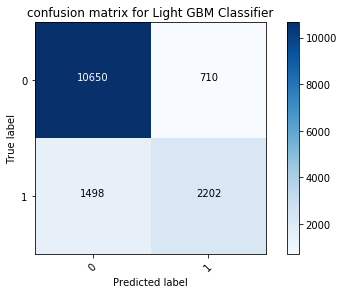

In [25]:
# 使用混淆图函数
types = ['0', '1']
plot_confusion_matrix(svm_confusion_matrix, classes=types, normalize=False,
                      title='confusion matrix for Light GBM Classifier')